<a href="https://colab.research.google.com/github/reenasharon05/Image-Classification/blob/master/Doc_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install portaudio19-dev python-pyaudio python3-pyaudio
!pip install PyAudio
!pip install speech_recognition

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-pyaudio
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for PyAudio (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for PyAudio
Failed to build PyAudio
ERROR: Could not build wheels for PyAudio, which is required to install pyproject.toml-based projects
ERROR: Could not find a version that satisfies the requirement speech_recognition (from versions: none)
ERROR: No matching distribution found for speech_recognition


In [ ]:
!pip install speech_recognition==3.8.1

ERROR: Could not find a version that satisfies the requirement speech_recognition==3.8.1 (from versions: none)
ERROR: No matching distribution found for speech_recognition==3.8.1


In [ ]:
import speech_recognition

ModuleNotFoundError: No module named 'speech_recognition'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
physical_devices =tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  0


In [ ]:
tf.__version__

'2.17.1'

Load the dataset

In [ ]:
dataset_path = '/content/drive/MyDrive/DATASETS/doc_image_dataset'

Preprocessing the train data and validation data
coverting into a std format(file type ) and std size(244x244 pixels)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load and preprocess the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/DATASETS/doc_image_dataset/training',          # Path to training folder
    image_size=(224, 224),    # Resize images to 224x224
    batch_size=32,            # Set batch size
    label_mode='categorical'  # One-hot encode the labels
)

# Load and preprocess the validation dataset
val_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/DATASETS/doc_image_dataset/validation',            # Path to validation folder
    image_size=(224, 224),    # Resize images to 224x224
    batch_size=32,            # Set batch size
    label_mode='categorical'  # One-hot encode the labels
)

# Preprocess images using MobileNetV2 preprocessing
train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y))
val_dataset = val_dataset.map(lambda x, y: (preprocess_input(x), y))


Found 36 files belonging to 5 classes.
Found 16 files belonging to 5 classes.


Found 52 files belonging to 5 classes.


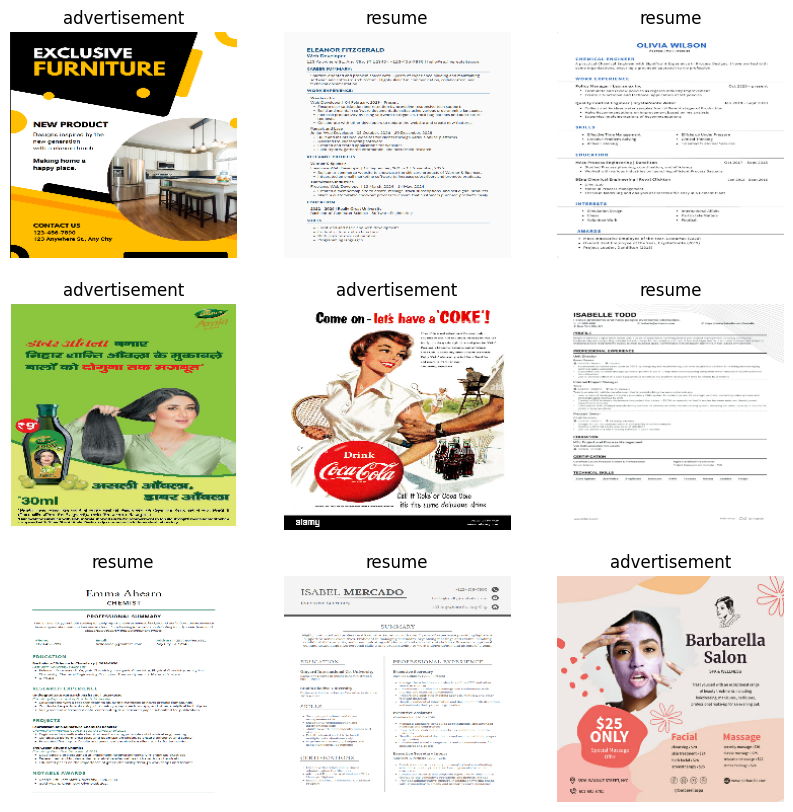

In [ ]:
'''
import tensorflow as tf
import matplotlib.pyplot as plt

# Load dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels='inferred',  # Automatically infers labels from folder names
    label_mode='categorical',  # One-hot encoded labels for multi-class classification
    image_size=(224, 224),  # Resize images to match MobileNetV2 input
    batch_size= 32  # Number of images per batch
)

# Split into train and validation sets
train_dataset = dataset.take(int(0.8 * len(dataset)))
val_dataset = dataset.skip(int(0.8 * len(dataset)))

# Preview some images
class_names = dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i])])
        plt.axis("off")
plt.show()
'''

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam


In [ ]:
# to check Ensure that all files in your dataset directories are valid images. Sometimes non-image files (e.g., .txt, .csv) or corrupted images can be present in your dataset folder.
import os
from PIL import Image

def check_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Check if it's a valid image
            except Exception as e:
                print(f"Invalid image or non-image file: {file_path}, Error: {e}")

check_images('/content/drive/MyDrive/DATASETS/doc_image_dataset/training')
check_images('/content/drive/MyDrive/DATASETS/doc_image_dataset/validation')


In [ ]:
train_dir = '/content/drive/MyDrive/DATASETS/doc_image_dataset/training'
val_dir = '/content/drive/MyDrive/DATASETS/doc_image_dataset/validation'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 713 images belonging to 5 classes.
Found 75 images belonging to 5 classes.


In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Create the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # 5 classes in your dataset
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Data Augmentation: Use more aggressive data augmentation to create variations in the data and prevent overfitting.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Create the data generators for training and validation data
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/DATASETS/doc_image_dataset/training', target_size=(224, 224), batch_size=32, class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory('/content/drive/MyDrive/DATASETS/doc_image_dataset/validation', target_size=(224, 224), batch_size=32, class_mode='categorical')

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


Found 713 images belonging to 5 classes.
Found 75 images belonging to 5 classes.


Regularization: Add L2 regularization or increase dropout to reduce overfitting.
python
Copy code


In [ ]:
from tensorflow.keras import regularizers
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))


Early Stopping: Use early stopping to halt training once the validation loss stops improving. This helps prevent overfitting and ensures the model generalizes better.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.8580 - loss: 0.4062 - val_accuracy: 0.7067 - val_loss: 0.7623
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.8699 - loss: 0.3858 - val_accuracy: 0.7333 - val_loss: 0.8035
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8885 - loss: 0.3379 - val_accuracy: 0.7200 - val_loss: 0.7568
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8531 - loss: 0.4427 - val_accuracy: 0.7067 - val_loss: 0.8269
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8939 - loss: 0.3537 - val_accuracy: 0.7333 - val_loss: 0.8156
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8459 - loss: 0.3995 - val_accuracy: 0.6800 - val_loss: 0.8739


In [ ]:
'''
old code before Data Augmentation,L2 regularization, and adding early stopping

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)
'''


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.7278 - loss: 0.8171 - val_accuracy: 0.4267 - val_loss: 1.1340
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.7607 - loss: 0.6677 - val_accuracy: 0.4533 - val_loss: 1.1256
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8175 - loss: 0.5243 - val_accuracy: 0.5600 - val_loss: 0.9844
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7988 - loss: 0.5170 - val_accuracy: 0.5733 - val_loss: 1.0082
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8288 - loss: 0.4643 - val_accuracy: 0.6267 - val_loss: 0.8711
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8508 - loss: 0.4513 - val_accuracy: 0.6267 - val_loss: 0.8437
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8539 - loss: 0.4416 - val_accuracy: 0.6000 - val_loss: 0.9377
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8724 - loss: 0.3757 - val_accuracy: 0.5733 - val_loss:

Visualize Training and

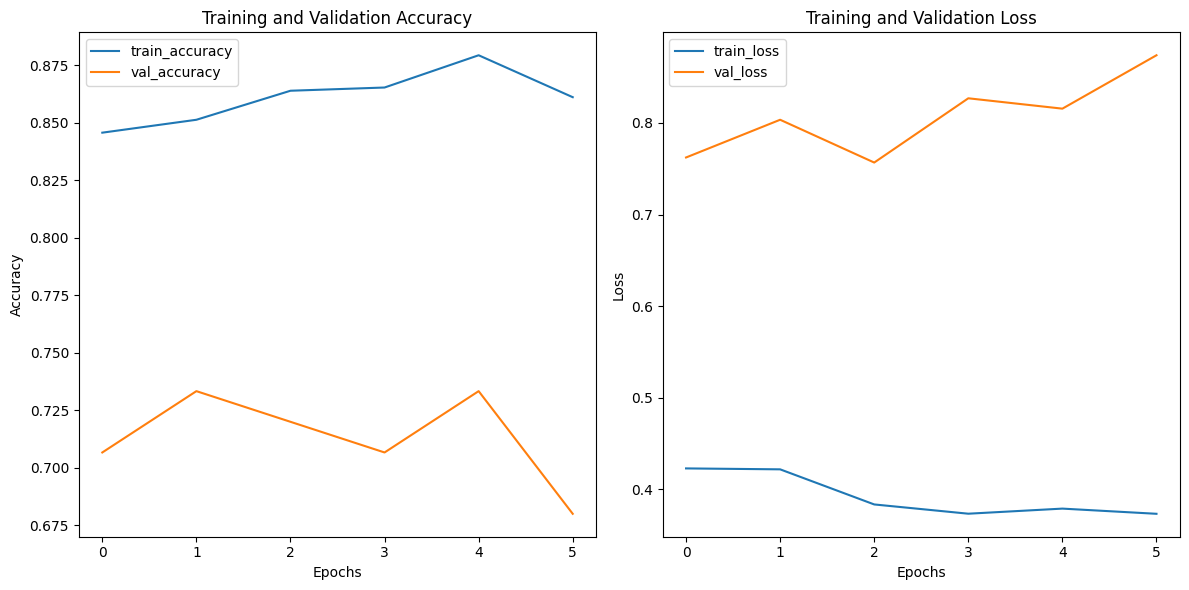

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 765ms/step - accuracy: 0.7077 - loss: 0.7658
Validation Loss: 0.7568132877349854
Validation Accuracy: 0.7200000286102295


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = '/content/drive/MyDrive/DATASETS/doc_image_dataset/test/Rectangle@2x-2-3.png'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict the class
pred = model.predict(img_array)
class_idx = np.argmax(pred, axis=1)

# Get the class label
class_labels = list(train_generator.class_indices.keys())  # Assuming the class order is the same in training
print(f"Predicted class: {class_labels[class_idx[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted class: resume_t


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 815ms/step


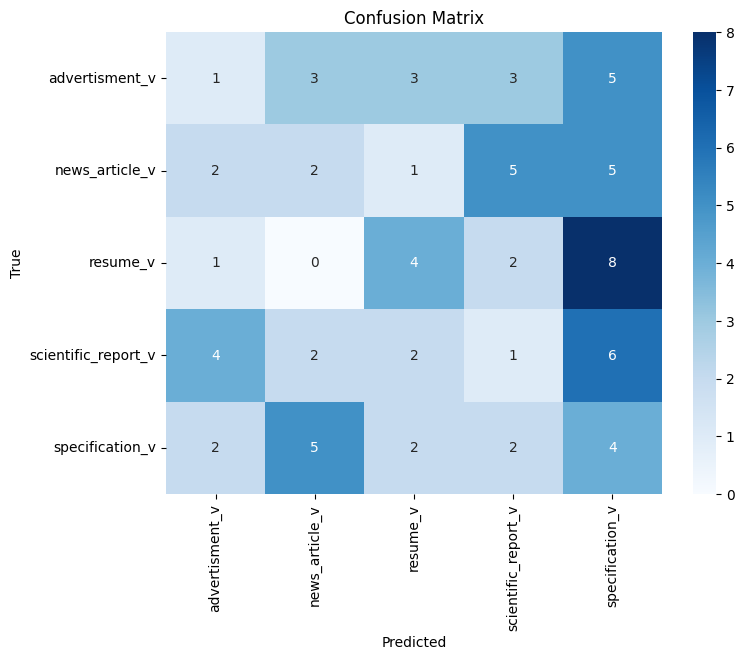

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Get predictions on the validation set
y_true = validation_generator.classes
y_pred = np.argmax(model.predict(validation_generator), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Save the entire model (architecture + weights)
model.save('path_to_save_model/my_model.h5')


In [ ]:
# Save the entire model (architecture + weights) in the native Keras format
model.save('path_to_save_model/my_model.keras')
